# Import Packages

![](https://i.imgur.com/jZqpV51.png)


In [61]:
from glob import glob
import tensorflow as tf
import numpy as np
import pandas as pd
from keras.applications import VGG16, ResNet101
from keras.preprocessing import image
from keras.models import Model
from keras.layers import *
from keras.metrics import categorical_accuracy, top_k_categorical_accuracy

import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import h5py

# Initialize the dataset

In [2]:
! wget --no-check-certificate https://www2.macs.hw.ac.uk/~js2001/Covid19Xray.zip

--2022-11-19 17:26:35--  https://www2.macs.hw.ac.uk/~js2001/Covid19Xray.zip
Resolving www2.macs.hw.ac.uk (www2.macs.hw.ac.uk)... 137.195.15.99
Connecting to www2.macs.hw.ac.uk (www2.macs.hw.ac.uk)|137.195.15.99|:443... connected.
  Unable to locally verify the issuer's authority.
HTTP request sent, awaiting response... 200 OK
Length: 88393633 (84M) [application/zip]
Saving to: ‘Covid19Xray.zip’

Covid19Xray.zip     100%[===================>]  84.30M  1.70MB/s    in 51s     

2022-11-19 17:27:27 (1.67 MB/s) - ‘Covid19Xray.zip’ saved [88393633/88393633]



In [3]:
! unzip /content/Covid19Xray.zip -d ./

Archive:  /content/Covid19Xray.zip
   creating: ./test/
   creating: ./test/NORMAL/
  inflating: ./test/NORMAL/NORMAL2-IM-0035-0001.jpeg  
  inflating: ./test/NORMAL/NORMAL2-IM-0052-0001.jpeg  
  inflating: ./test/NORMAL/NORMAL2-IM-0058-0001.jpeg  
  inflating: ./test/NORMAL/NORMAL2-IM-0059-0001.jpeg  
  inflating: ./test/NORMAL/NORMAL2-IM-0072-0001.jpeg  
  inflating: ./test/NORMAL/NORMAL2-IM-0073-0001.jpeg  
  inflating: ./test/NORMAL/NORMAL2-IM-0092-0001.jpeg  
  inflating: ./test/NORMAL/NORMAL2-IM-0105-0001.jpeg  
  inflating: ./test/NORMAL/NORMAL2-IM-0110-0001.jpeg  
  inflating: ./test/NORMAL/NORMAL2-IM-0111-0001.jpeg  
  inflating: ./test/NORMAL/NORMAL2-IM-0112-0001.jpeg  
  inflating: ./test/NORMAL/NORMAL2-IM-0117-0001.jpeg  
  inflating: ./test/NORMAL/NORMAL2-IM-0120-0001.jpeg  
  inflating: ./test/NORMAL/NORMAL2-IM-0123-0001.jpeg  
  inflating: ./test/NORMAL/NORMAL2-IM-0130-0001.jpeg  
  inflating: ./test/NORMAL/NORMAL2-IM-0131-0001.jpeg  
  inflating: ./test/NORMAL/NORMAL2-I

In [7]:
folder = glob('/content/train/*')

In [4]:
IMAGE_SIZE = [224,224]

In [10]:
#use VGG to load images
vgg = VGG16(input_shape = IMAGE_SIZE + [3], weights='imagenet', include_top=False)

for layer in vgg.layers:
    layer.trainable = False

In [8]:
x = Flatten()(vgg.output)
preds = Dense(512, activation='relu')(x)
predictions = Dense(len(folder), activation='softmax')(preds)

vgg_model = Model(inputs=vgg.input, outputs=predictions)

In [9]:
vgg_model.compile(loss='categorical_crossentropy',
  optimizer='adam',
  metrics=[categorical_accuracy])

# Build Model epoche = 1 Verbose = 1

In [62]:
test_datagen = ImageDataGenerator(rescale = 1./255)
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

In [63]:
train_set = train_datagen.flow_from_directory('/content/train', 
                                              target_size = (224, 224),
                                              batch_size = 32, 
                                              class_mode = 'categorical'
                                             )

# for test data
test_set = test_datagen.flow_from_directory('/content/test',
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'categorical'
                                           )

Found 148 images belonging to 2 classes.
Found 40 images belonging to 2 classes.


In [17]:
filepath = "vgg16_model.h5"
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_categorical_accuracy', verbose=1, 
                             save_best_only=True, mode='max')

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_categorical_accuracy', factor=0.5, patience=2, 
                                   verbose=1, mode='max', min_lr=0.00001)
                              
                              
callbacks_list = [checkpoint, reduce_lr]

history = vgg_model.fit_generator(train_set, steps_per_epoch=len(train_set), 
                              #class_weight=class_weights,
                    validation_data=test_set,
                    validation_steps=len(test_set),
                    epochs=1, verbose=1,
                   callbacks=callbacks_list)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  app.launch_new_instance()


5/5 [==============================] - ETA: 0s - loss: 8.5908 - categorical_accuracy: 0.5000  
Epoch 1: val_categorical_accuracy improved from -inf to 0.50000, saving model to vgg16_model.h5
5/5 [==============================] - 115s 24s/step - loss: 8.5908 - categorical_accuracy: 0.5000 - val_loss: 3.4470 - val_categorical_accuracy: 0.5000 - lr: 0.0010


In [18]:
y_pred = vgg_model.predict_generator(test_set)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  """Entry point for launching an IPython kernel.


In [19]:
y_pred = np.argmax(y_pred, axis=1)
y_pred

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [20]:
test_set.class_indices

{'NORMAL': 0, 'PNEUMONIA': 1}

In [21]:
batch_size = 32
val_steps = np.ceil(len(test_set) / batch_size)

val_loss, val_cat_acc = \
vgg_model.evaluate_generator(test_set, 
                        steps=val_steps)

print('val_loss:', val_loss)
print('val_cat_acc:', val_cat_acc)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  


val_loss: 3.6371066570281982
val_cat_acc: 0.46875


In [22]:
vgg_model.load_weights('vgg16_model.h5')

val_loss, val_cat_acc = \
vgg_model.evaluate_generator(test_set, 
                        steps=val_steps)

print('val_loss:', val_loss)
print('val_cat_acc:', val_cat_acc)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  """


val_loss: 3.6818487644195557
val_cat_acc: 0.46875


## Confusion Matrix and ROC Graph

In [23]:
from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(test_set.classes,y_pred)
cm

array([[ 0, 20],
       [ 0, 20]])

In [44]:
tn, fp, fn, tp = cm.ravel()
print('False Positives : {}'.format(fp))
print('False Negatives: {}'. format(fn))
print('True Positives : {}'.format(tp))
print('True Negatives : {}'.format(tn))

False Positives : 20
False Negatives: 0
True Positives : 20
True Negatives : 0


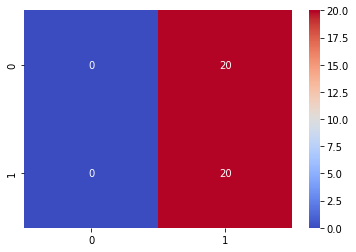

In [43]:
sns.heatmap(cm, annot=True, cmap='coolwarm')

In [45]:
print("Our model's accuracy is {}%".format(((cm[0][0] + cm[1][1])/40)*100))

Our model's accuracy is 50.0%


In [26]:
print('The Classification Report : \n{}'.format(classification_report(test_set.classes,y_pred)))

The Classification Report : 
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        20
           1       0.50      1.00      0.67        20

    accuracy                           0.50        40
   macro avg       0.25      0.50      0.33        40
weighted avg       0.25      0.50      0.33        40



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


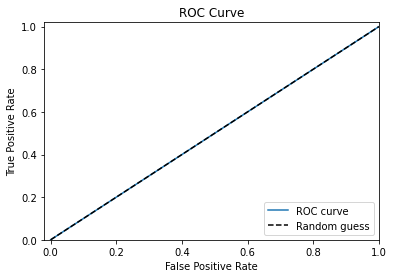

In [58]:
from sklearn.metrics import roc_curve
%matplotlib inline
fpr, tpr, thresholds = roc_curve(test_set.classes, y_pred)
# create plot
plt.plot(fpr, tpr, label='ROC curve')
plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
_ = plt.xlabel('False Positive Rate')
_ = plt.ylabel('True Positive Rate')
_ = plt.title('ROC Curve')
_ = plt.xlim([-0.02, 1])
_ = plt.ylim([0, 1.02])
_ = plt.legend(loc="lower right")

In [59]:
from sklearn.metrics import roc_auc_score

roc_auc_score(test_set.classes, y_pred)

0.5

# Build Model epoche = 5 Verbose = 5

In [64]:
test_datagen = ImageDataGenerator(rescale = 1./255)
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

In [65]:
train_set = train_datagen.flow_from_directory('/content/train', 
                                              target_size = (224, 224),
                                              batch_size = 32, 
                                              class_mode = 'categorical'
                                             )

# for test data
test_set = test_datagen.flow_from_directory('/content/test',
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'categorical'
                                           )

Found 148 images belonging to 2 classes.
Found 40 images belonging to 2 classes.


In [66]:
filepath = "vgg16_model_1.h5"
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_categorical_accuracy', verbose=1, 
                             save_best_only=True, mode='max')

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_categorical_accuracy', factor=0.5, patience=2, 
                                   verbose=1, mode='max', min_lr=0.00001)
                              
                              
callbacks_list = [checkpoint, reduce_lr]

history = vgg_model.fit_generator(train_set, steps_per_epoch=len(train_set), 
                              #class_weight=class_weights,
                    validation_data=test_set,
                    validation_steps=len(test_set),
                    epochs=5, verbose=5,
                   callbacks=callbacks_list)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  app.launch_new_instance()


Epoch 1/5

Epoch 1: val_categorical_accuracy improved from -inf to 0.50000, saving model to vgg16_model_1.h5
Epoch 2/5

Epoch 2: val_categorical_accuracy improved from 0.50000 to 0.90000, saving model to vgg16_model_1.h5
Epoch 3/5

Epoch 3: val_categorical_accuracy improved from 0.90000 to 0.95000, saving model to vgg16_model_1.h5
Epoch 4/5

Epoch 4: val_categorical_accuracy did not improve from 0.95000
Epoch 5/5

Epoch 5: val_categorical_accuracy improved from 0.95000 to 1.00000, saving model to vgg16_model_1.h5


In [67]:
y_pred = vgg_model.predict_generator(test_set)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  """Entry point for launching an IPython kernel.


In [68]:
y_pred = np.argmax(y_pred, axis=1)
y_pred

array([0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0,
       0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1])

In [69]:
test_set.class_indices

{'NORMAL': 0, 'PNEUMONIA': 1}

In [70]:
batch_size = 32
val_steps = np.ceil(len(test_set) / batch_size)

val_loss, val_cat_acc = \
vgg_model.evaluate_generator(test_set, 
                        steps=val_steps)

print('val_loss:', val_loss)
print('val_cat_acc:', val_cat_acc)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  


val_loss: 0.09297025203704834
val_cat_acc: 1.0


In [71]:
vgg_model.load_weights('vgg16_model_1.h5')

val_loss, val_cat_acc = \
vgg_model.evaluate_generator(test_set, 
                        steps=val_steps)

print('val_loss:', val_loss)
print('val_cat_acc:', val_cat_acc)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  """


val_loss: 0.07915050536394119
val_cat_acc: 1.0


## Confusion Matrix and ROC Graph

In [72]:
from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(test_set.classes,y_pred)
cm

array([[10, 10],
       [10, 10]])

In [73]:
tn, fp, fn, tp = cm.ravel()
print('False Positives : {}'.format(fp))
print('False Negatives: {}'. format(fn))
print('True Positives : {}'.format(tp))
print('True Negatives : {}'.format(tn))

False Positives : 10
False Negatives: 10
True Positives : 10
True Negatives : 10


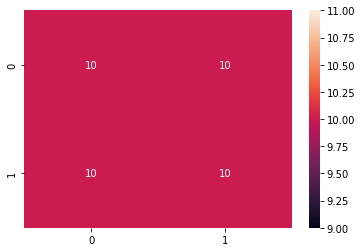

In [79]:
sns.heatmap(cm, annot=True)

In [80]:
print("Our model's accuracy is {}%".format(((cm[0][0] + cm[1][1])/40)*100))

Our model's accuracy is 50.0%


In [81]:
print('The Classification Report : \n{}'.format(classification_report(test_set.classes,y_pred)))

The Classification Report : 
              precision    recall  f1-score   support

           0       0.50      0.50      0.50        20
           1       0.50      0.50      0.50        20

    accuracy                           0.50        40
   macro avg       0.50      0.50      0.50        40
weighted avg       0.50      0.50      0.50        40



In [82]:
y_pred

array([0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0,
       0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1])

In [84]:
from sklearn.metrics import roc_auc_score

roc_auc_score(test_set.classes, y_pred)

0.5

# Build Model epoche = 10 Verbose = 10

In [85]:
test_datagen = ImageDataGenerator(rescale = 1./255)
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

In [86]:
train_set = train_datagen.flow_from_directory('/content/train', 
                                              target_size = (224, 224),
                                              batch_size = 32, 
                                              class_mode = 'categorical'
                                             )

# for test data
test_set = test_datagen.flow_from_directory('/content/test',
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'categorical'
                                           )

Found 148 images belonging to 2 classes.
Found 40 images belonging to 2 classes.


In [87]:
filepath = "vgg16_model_2.h5"
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_categorical_accuracy', verbose=1, 
                             save_best_only=True, mode='max')

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_categorical_accuracy', factor=0.5, patience=2, 
                                   verbose=1, mode='max', min_lr=0.00001)
                              
                              
callbacks_list = [checkpoint, reduce_lr]

history = vgg_model.fit_generator(train_set, steps_per_epoch=len(train_set), 
                              #class_weight=class_weights,
                    validation_data=test_set,
                    validation_steps=len(test_set),
                    epochs=10, verbose=10,
                   callbacks=callbacks_list)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  app.launch_new_instance()


Epoch 1/10

Epoch 1: val_categorical_accuracy improved from -inf to 0.95000, saving model to vgg16_model_2.h5
Epoch 2/10

Epoch 2: val_categorical_accuracy did not improve from 0.95000
Epoch 3/10

Epoch 3: val_categorical_accuracy did not improve from 0.95000

Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 4/10

Epoch 4: val_categorical_accuracy improved from 0.95000 to 0.97500, saving model to vgg16_model_2.h5
Epoch 5/10

Epoch 5: val_categorical_accuracy did not improve from 0.97500
Epoch 6/10

Epoch 6: val_categorical_accuracy improved from 0.97500 to 1.00000, saving model to vgg16_model_2.h5
Epoch 7/10

Epoch 7: val_categorical_accuracy did not improve from 1.00000
Epoch 8/10

Epoch 8: val_categorical_accuracy did not improve from 1.00000

Epoch 8: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Epoch 9/10

Epoch 9: val_categorical_accuracy did not improve from 1.00000
Epoch 10/10

Epoch 10: val_categorical_accuracy did not impr

In [88]:
y_pred = vgg_model.predict_generator(test_set)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  """Entry point for launching an IPython kernel.


In [89]:
y_pred = np.argmax(y_pred, axis=1)
y_pred

array([1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1,
       0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1])

In [90]:
test_set.class_indices

{'NORMAL': 0, 'PNEUMONIA': 1}

In [91]:
batch_size = 32
val_steps = np.ceil(len(test_set) / batch_size)

val_loss, val_cat_acc = \
vgg_model.evaluate_generator(test_set, 
                        steps=val_steps)

print('val_loss:', val_loss)
print('val_cat_acc:', val_cat_acc)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  


val_loss: 0.06526544690132141
val_cat_acc: 1.0


In [92]:
vgg_model.load_weights('vgg16_model_2.h5')

val_loss, val_cat_acc = \
vgg_model.evaluate_generator(test_set, 
                        steps=val_steps)

print('val_loss:', val_loss)
print('val_cat_acc:', val_cat_acc)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  """


val_loss: 0.08113817870616913
val_cat_acc: 1.0


## Confusion Matrix and ROC Graph

In [93]:
from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(test_set.classes,y_pred)
cm

array([[11,  9],
       [ 9, 11]])

In [94]:
tn, fp, fn, tp = cm.ravel()
print('False Positives : {}'.format(fp))
print('False Negatives: {}'. format(fn))
print('True Positives : {}'.format(tp))
print('True Negatives : {}'.format(tn))

False Positives : 9
False Negatives: 9
True Positives : 11
True Negatives : 11


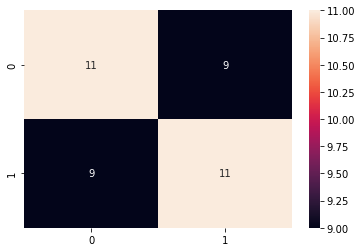

In [95]:
sns.heatmap(cm, annot=True)

In [96]:
print("Our model's accuracy is {}%".format(((cm[0][0] + cm[1][1])/40)*100))

Our model's accuracy is 55.00000000000001%


In [97]:
print('The Classification Report : \n{}'.format(classification_report(test_set.classes,y_pred)))

The Classification Report : 
              precision    recall  f1-score   support

           0       0.55      0.55      0.55        20
           1       0.55      0.55      0.55        20

    accuracy                           0.55        40
   macro avg       0.55      0.55      0.55        40
weighted avg       0.55      0.55      0.55        40



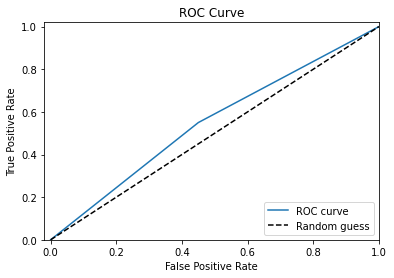

In [101]:
from sklearn.metrics import roc_curve
%matplotlib inline
fpr, tpr, thresholds = roc_curve(test_set.classes, y_pred)
# create plot
plt.plot(fpr, tpr, label='ROC curve')
plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
_ = plt.xlabel('False Positive Rate')
_ = plt.ylabel('True Positive Rate')
_ = plt.title('ROC Curve')
_ = plt.xlim([-0.02, 1])
_ = plt.ylim([0, 1.02])
_ = plt.legend(loc="lower right")

In [100]:
from sklearn.metrics import roc_auc_score

roc_auc_score(test_set.classes, y_pred)

0.55